# EFAS6: parameters
***

**Author**: Chus Casado Rodríguez<br>
**Date**: 04-03-2025<br>

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import yaml
from pathlib import Path
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import geopandas as gpd
from shapely.geometry import Point
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import pickle

In [2]:
from lisfloodreservoirs import read_attributes#, read_timeseries
from lisfloodreservoirs.models import get_model
from lisfloodreservoirs.utils.metrics import compute_performance

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
# from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

## 1 Configuration

In [4]:
system = 'EFAS6'

# paths
data_dir = Path('/eos/jeodpp/home/users/casadje/data')
res_dir = data_dir / system / 'reservoirs'
out_dir = res_dir / 'parameters'
plot_dir = out_dir / 'plots'
plot_dir.mkdir(parents=True, exist_ok=True)
model_dir = Path('./results/all')

# PARAMETER ESTIMATOR MODEL
# -------------------------

# observational datasets
data_version = {
    'US': 'v2.0',
    'ES': 'v3.0',
    'MX': 'v1.0',
    'BR': 'v1.0',
}

# reservoir routine
reservoir_model = 'hanazaki_2pars'

# performance metric and minimum value for the calibration to be used
metric = 'KGE'
perf_thr = 0.25

# parameters
par_range ={
    'alpha': (0.2, 0.99),
    'beta': (0.001, 0.999), 
    'gamma': (0.001, 0.999),
    'delta': (0.1, 0.5),
    'epsilon': (0.001, 0.999),
}
parameter_names = {
    'alpha': 'flood_storage',
    'delta': 'outflow_factor'
}

## Data

### Reservoirs

In [5]:
idx_name = 'GDW_ID'

# load reservoir table
xls_file = list((res_dir).glob(f'{system.lower()}_reservoirs_*.xlsx'))[-1]
reservoirs = []
for sheet in ['as_reservoirs', 'as_lakes']:
    df = pd.read_excel(xls_file, sheet_name=sheet, index_col=idx_name)
    df['TYPE'] = sheet
    reservoirs.append(df)
reservoirs = pd.concat(reservoirs, axis=0)
# reservoirs = pd.concat([pd.read_excel(xls_file, sheet_name=sheet, index_col=idx_name) for sheet in ['as_reservoirs', 'as_lakes']], axis=0)

# convert to GeoPandas
reservoirs = gpd.GeoDataFrame(
    data=reservoirs,
    geometry=[Point(xy) for xy in zip(reservoirs.LisfloodX, reservoirs.LisfloodY)],
    crs='epsg:4326'
)

reservoirs.shape

(1542, 28)

### Attributes

In [6]:
# load attributes
attributes = read_attributes(res_dir / 'attributes', reservoirs=reservoirs.index.tolist(), index_col=idx_name)
attributes.columns = attributes.columns.str.lower()

attributes.shape

(1542, 30)

In [7]:
attributes.isnull().any(axis=1).sum()

495

### Reservoir parameters

In [8]:
# pars_calib = []
# for country, version in data_version.items():

#     # load optimal parameters
#     pars = pd.DataFrame(dtype=float)
#     path = data_dir / f'ResOps{country}' / 'results' / reservoir_model / 'calibration' / run
#     for file in path.glob('*samples.csv'):
#         # reservoir ID
#         grand_id = int(file.stem.split('_')[0])
#         if grand_id not in map_grand_idx:
#             continue
#         gdw_id = map_grand_idx[grand_id]
#         # extract best sample from the calibration
#         samples = pd.read_csv(file)
#         mask_cols = samples.columns.str.startswith('par')
#         parvalues = samples.loc[[samples.like1.idxmin()], mask_cols]
#         parvalues.index = [gdw_id]
#         parvalues.index.name = idx_name
#         parvalues.rename(columns={col: col[3:] for col in parvalues.columns if col.startswith('par')}, inplace=True)
#         pars = pd.concat((pars, parvalues), axis=0)
#     pars.index.name = idx_name
    
#     pars_calib.append(pars)

# pars_calib = pd.concat(pars_calib, axis=1).sort_index()

In [9]:
results = []
# default reservoir limits
limits_def = pd.DataFrame(dtype=float)
for country, version in data_version.items():

    path_runs = {
        'default': data_dir / f'ResOps{country}' / 'results' / reservoir_model / 'default',
        'storage': data_dir / f'ResOps{country}' / 'results' / reservoir_model / 'calibration' / 'storage',
        'outflow': data_dir / f'ResOps{country}' / 'results' / reservoir_model / 'calibration' / 'outflow',
        'bivariate': data_dir / f'ResOps{country}' / 'results' / reservoir_model / 'calibration' / 'bivariate'
    }
    
    runs = []
    for run, path in path_runs.items():
        # optimal parameters
        parameters = pd.DataFrame(dtype=float)
        if run == 'default':
            for file in path.glob('*parameters.yml'):
                # reservoir ID
                ID = int(file.stem.split('_')[0])
                # extract alpha
                with open(file, 'r') as f:
                    lims = yaml.safe_load(f)
                limits_def = pd.concat((limits_def, pd.DataFrame({ID: lims}).transpose()), axis=0)
                parameters.loc[ID, 'alpha'] = lims['Vf'] / lims['Vtot']
                if reservoir_model.endswith('5pars'):
                    parameters.loc[ID, 'beta'] = (lims['Vtot'] - lims['Ve']) / (lims['Vtot'] - lims['Vf'])
                    parameters.loc[ID, 'gamma'] = lims['Vmin'] / lims['Vf'] 
                    parameters.loc[ID, 'epsilon'] = lims['Qn'] / lims['Qf']
            parameters['delta'] = 0.30
        else:
            for file in path.glob('*samples.csv'):
                # reservoir ID
                ID = int(file.stem.split('_')[0])
                # extract best sample from the calibration
                samples = pd.read_csv(file)
                mask_cols = samples.columns.str.startswith('par')
                parvalues = samples.loc[[samples.like1.idxmin()], mask_cols]
                parvalues.index = [ID]
                parvalues.index.name = 'ID'
                parvalues.rename(columns={col: col[3:] for col in parvalues.columns if col.startswith('par')}, inplace=True)
                parameters = pd.concat((parameters, parvalues), axis=0)
        parameters.index.name = 'ID'

        # performance
        performance = pd.DataFrame(dtype=float)
        for file in path.glob('*performance.csv'):
            # reservoir ID
            ID = int(file.stem.split('_')[0])
            # extract best sample from the calibration
            perf = pd.read_csv(file, index_col='metric')
            perf = perf.loc[[metric], ['storage', 'outflow']]
            perf.index = [ID]
            perf.index.name = 'ID'
            perf.columns = [f'{metric}_{col}' for col in perf.columns]
            performance = pd.concat((performance, perf), axis=0)

        # concat all results
        runs.append(xr.Dataset(pd.concat((parameters, performance), axis=1)).expand_dims(dim={'run': [run]}))

    # merge in a single Dataset
    runs = xr.merge(runs)
    runs = runs.reindex(run=['default', 'storage', 'outflow', 'bivariate'])
    results.append(runs)
results = xr.merge(results)

In [10]:
# select the reservoirs that are included in EFAS/GloFAS and rename the dimension
map_grand_idx = {grand_id: idx for idx, grand_id in reservoirs.GRAND_ID.items() if not pd.isna(grand_id) and grand_id in results.ID.data}
results = results.sel(ID=list(map_grand_idx))
results['ID'] = [map_grand_idx[grand_id] for grand_id in results.ID.data]
results = results.rename({'ID': idx_name})

### Model

In [11]:
# load model
with open(model_dir / 'random_forest_2' / 'random_forest_2par.pkl', 'rb') as file:
    model = pickle.load(file)

# feature names
features = model.feature_names_in_

## Reservoir parameters 

### Calibrated

In [12]:
# extract the calibrated parameters as a DataFrame
pars_calib = pd.concat([results.sel(run=run)[par].to_pandas() for par in list(parameter_names)], axis=1)
pars_calib.columns = list(parameter_names)
pars_calib['parameters'] = 'calibrated'

# keep only those with performance in the calibration
mask_performance = (pd.concat([results[f'{metric}_{var}'].sel(run=run).to_pandas() for var in ['storage', 'outflow']], axis=1) < perf_thr).any(axis=1)
pars_calib = pars_calib[~mask_performance]

print(pars_calib.shape)
pars_calib.head()

(68, 3)


,alpha,delta,parameters
GDW_ID,,,
1405,0.421110,0.101907,calibrated
1410,0.592934,0.108765,calibrated
1422,0.599445,0.100032,calibrated
1423,0.811776,0.102334,calibrated
1430,0.587339,0.113587,calibrated


### Estimated

In [13]:
# predict parameters
ids = reservoirs.index.difference(pars_calib.index)
pars_est = pd.DataFrame(
    data=model.predict(attributes.loc[ids, features]),
    index=ids,
    columns=parameter_names.keys()
)
pars_est['parameters'] = 'estimated'

print(pars_est.shape)
pars_est.head()

(1474, 3)


,alpha,delta,parameters
GDW_ID,,,
33,0.570053,0.226099,estimated
35,0.631682,0.215105,estimated
36,0.537867,0.215556,estimated
37,0.624472,0.219941,estimated
39,0.519349,0.215043,estimated


### Combine

In [14]:
# combine and concat with reservoir table
parameters = pd.concat([pars_calib, pars_est], axis=0).sort_index().round(6)

print(parameters.shape)
parameters.head()

(1542, 3)


,alpha,delta,parameters
GDW_ID,,,
33,0.570053,0.226099,estimated
35,0.631682,0.215105,estimated
36,0.537867,0.215556,estimated
37,0.624472,0.219941,estimated
39,0.519349,0.215043,estimated


#### Analyse

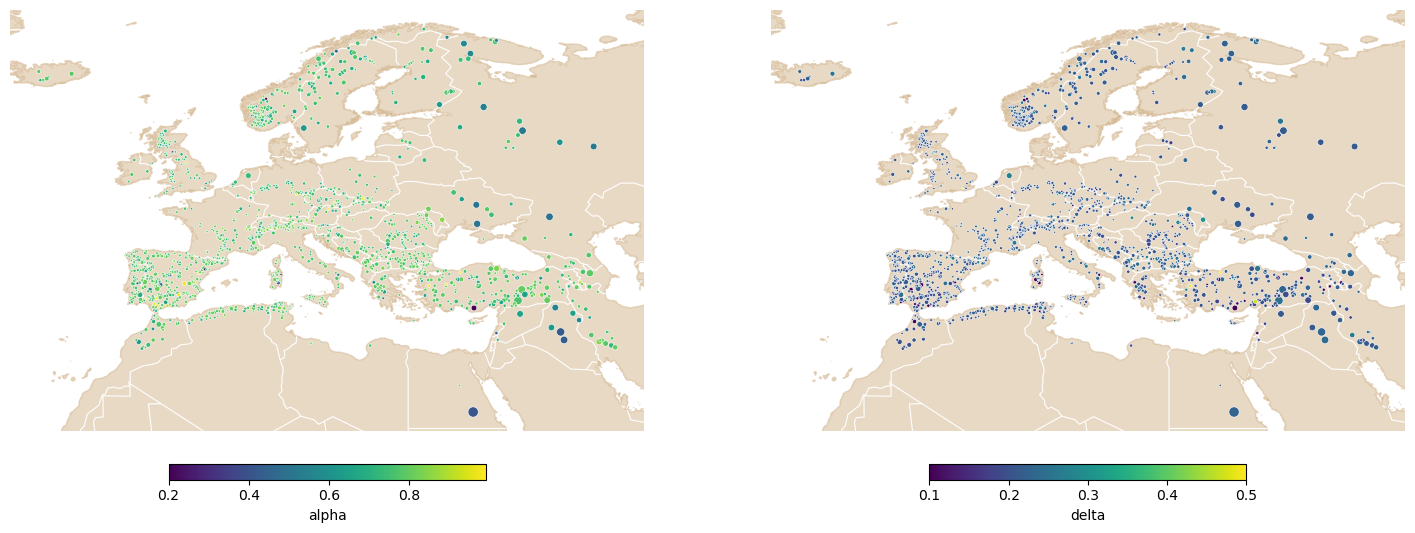

In [15]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 8.5), subplot_kw=dict(projection=ccrs.PlateCarree()))
for ax, par in zip(axes, ['alpha', 'delta']):
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='tan'), alpha=.5, zorder=0)
    ax.add_feature(cfeature.BORDERS, edgecolor='w', linewidth=0.8, zorder=1)
    sct = ax.scatter(
        reservoirs.geometry.x,
        reservoirs.geometry.y,
        s=np.cbrt(reservoirs.CAP_MCM),
        c=parameters[par],
        edgecolor='w',
        lw=.4,
        cmap='viridis',
        norm=mcolors.Normalize(*par_range[par])
    )
    cbar = plt.colorbar(sct, orientation='horizontal', pad=.05, shrink=.5)#, ax=ax)
    # ax.set_extent([-180, 180, -90, 90])
    cbar.set_label(par)
    ax.axis('off');
plt.savefig(plot_dir / f'parameter_maps_{system}.jpg', dpi=300, bbox_inches='tight')

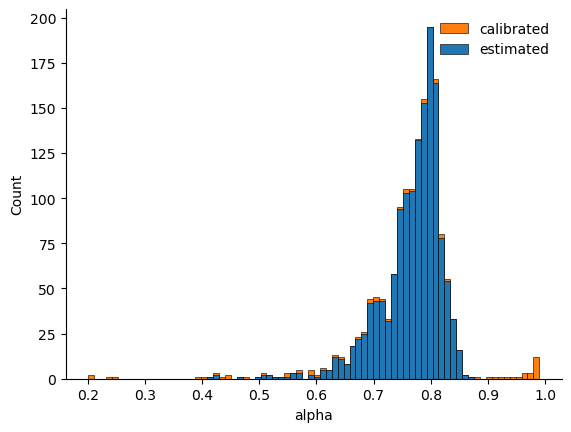

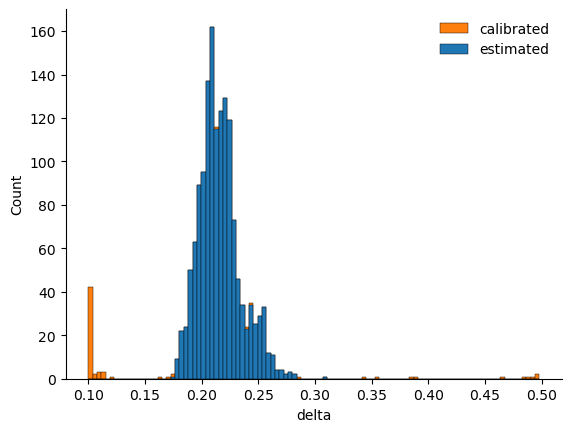

In [18]:
for par, name in parameter_names.items():
    fig, ax = plt.subplots()
    bins = np.histogram_bin_edges(parameters[par], bins="auto")
    sns.histplot(parameters[par], bins=bins, ax=ax, color='C1', alpha=1, label='calibrated')
    sns.histplot(pars_est[par], bins=bins, ax=ax, color='C0', alpha=1, label='estimated')
    # ax.set(xlim=par_range[par])
    ax.legend(frameon=False)
    ax.spines[['top', 'right']].set_visible(False)
    plt.savefig(plot_dir / f'{name}.jpg', dpi=300, bbox_inches='tight')

### Export

#### TXT files

In [19]:
for par, name in parameter_names.items():
    txt_file = out_dir / f'reservoirs_{system.lower()}_{name}.txt'
    parameters[par].to_csv(
        txt_file,
        sep='\t',
        header=None,
        float_format='%.6f'
    )
    print(f'Parameter {par} saved in file {txt_file}')

Parameter alpha saved in file /eos/jeodpp/home/users/casadje/data/EFAS6/reservoirs/parameters/reservoirs_efas6_flood_storage.txt
Parameter delta saved in file /eos/jeodpp/home/users/casadje/data/EFAS6/reservoirs/parameters/reservoirs_efas6_outflow_factor.txt


#### Excel

In [21]:
# add parameters to the reservoir table
reservoirs.drop(list(parameter_names), axis=1, inplace=True, errors='ignore')
reservoirs = pd.concat((reservoirs, parameters), axis=1)
reservoirs.rename(columns=parameter_names, inplace=True)

# save table of reservoirs as Excel
xls_file_out = f'{xls_file.parent}/{xls_file.stem}+parameters.xlsx'
with pd.ExcelWriter(xls_file_out, engine='openpyxl') as writer:
    for sheet in reservoirs.TYPE.unique():
        mask = reservoirs.TYPE == sheet
        reservoirs[mask].drop(['TYPE', 'geometry'], axis=1).to_excel(writer, sheet_name=sheet, float_format='%.4f')
print(f'Reservoir Excel table saved in : {xls_file_out}')

Reservoir Excel table saved in : /eos/jeodpp/home/users/casadje/data/EFAS6/reservoirs/efas6_reservoirs_20250303+parameters.xlsx


In [ ]:
# reservoirs.rename(columns=parameter_names, inplace=True)
# xls_file_out = f'{xls_file.parent}/{xls_file.stem}+parameters.xlsx'
# reservoirs.drop('geometry', axis=1).to_excel(xls_file_out)
# print(f'Reservoirs Excel file saved in {xls_file_out}')